# Kirsh (2009), Fig. 3
In this example we reproduce the results of Kirsh et al. (2009) Fig. 3, using a 2.3$M_{\oplus}$ planet embedded in a planetesimal disk undergoing migration.

In [4]:
import rebound
import numpy as np
import time as timing
import os

## Setup
First we need to setup the problem with all the various functions we'll need.

In [5]:
#various powerlaws we'll need
def rand_powerlaw(min_v, max_v, slope):
    y = np.random.uniform()
    if slope == -1:
        return np.exp(y*np.log(max_v/min_v) + np.log(min_v))
    else:
        pow_max = pow(max_v, slope+1.)
        pow_min = pow(min_v, slope+1.)
        return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

In [3]:
#calculating the semi-major axis
def get_a(sim,planet_index):
    com = sim.calculate_com()
    p = sim.particles[planet_index]
    mu = sim.G*(com.m+p.m)
    dvx = p.vx - com.vx
    dvy = p.vy - com.vy
    dvz = p.vz - com.vz
    v2 = dvx*dvx + dvy*dvy + dvz*dvz
    dx = p.x - com.x
    dy = p.y - com.y
    dz = p.z - com.z
    r = np.sqrt(dx*dx + dy*dy + dz*dz)
    return -mu/(v2 - 2.*mu/r)

In [4]:
#The outputs for the integrator
def get_outputs(sim,E0,start_t,filename,write_t,write_log,write_lin):
    with open(filename, "a") as writefile:
        dE = abs((sim.calculate_energy() - E0)/E0)
        current_t = timing.time()-start_t
        a = get_a(sim,sim.N_active-1)
        N_mini = 0
        #if(sim.integrator == "hybarid"):
        #    N_mini = sim.ri_hybarid.mini.N
        too_large = sim.ri_hybarid.timestep_too_large_warning
        writefile.write(','.join(map(str,(sim.t,dE,a,sim.N,N_mini,current_t,too_large))) +"\n")
    write_t = min(write_t*write_log,write_t*write_lin)
    if write_t < sim.t + sim.dt:
        write_t = sim.t + sim.dt
    return write_t

In [5]:
def get_filename(HSR,dt,run):
    return "output/Kirsh_HSR%d_dt%.4f_May25rearth_%d.txt"%(HSR,dt,run)

In [16]:
#The Kirsh problem
def problem(HSR, dt, seed, run):
    
    #output initialization stuff
    filename = get_filename(HSR,dt,run)
    try:
        os.remove(filename)
    except OSError:
        pass
    np.random.seed(seed=seed)
    write_t = dt      #writing to file: ini
    write_log = 1.01  #writing to file: log output
    write_lin = 100   #writing to file: linear output every write_lin years

    #initialize the simulation
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hybarid"
    sim.ri_hybarid.switch_radius = HSR
    sim.ri_hybarid.CE_radius = 15.
    sim.dt = dt
    sim.testparticle_type = 1
    sim.usleep = -1
    tmax = 7e4*6.283
    
    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.boundary = "open"
    boxsize = 100.
    sim.configure_box(boxsize)
    sim.collisions_track_dE = 1
    
    #add sun
    sim.add(m=1.,r=0.005)
    
    #Super Earth
    m_earth = 0.000003003
    m_planet = m_earth*2.3
    a_planet = 25
    r_planet = 0.0000788215 #radius of particle using 2g/cm^3 (AU)
    #r_planet = 4.68e-4 #Jupiter inflated mass
    sim.add(m=m_planet,r=r_planet,a=a_planet,e=0,inc=0.001)
    
    sim.N_active = sim.N
    
    #planetesimal disk
    print "Populating planetesimal disk for run %d"%run
    m_pl = m_planet/600.
    N_pl = 230*m_earth/m_pl
    r_pl = 0.00000934532
    disk_min_a = a_planet - 10.5
    disk_max_a = a_planet + 10.5
    while sim.N < (N_pl + sim.N_active):
        a = rand_powerlaw(disk_min_a, disk_max_a, 1)
        e = rand_rayleigh(0.01)
        inc = rand_rayleigh(0.005)
        Omega = rand_uniform(0,2*np.pi)
        omega = rand_uniform(0,2*np.pi)
        f = rand_uniform(0,2*np.pi)
        sim.add(m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f) #This is very(!) slow
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    print "Begin simulation for run %d"%run
    start_t = timing.time()
    while sim.t < tmax:
        sim.integrate(write_t)
        write_t = get_outputs(sim,E0,start_t,filename,write_t,write_log,write_lin)
        
    print("Run %d complete in %.2f s with dE=%e."% (run,timing.time()-start_t,abs((sim.calculate_energy() - E0)/E0)))

## Run the problem
Now let's run the problem, making use of the multiprocessing module.

In [6]:
#Setup parameters
#dt = 12.76
dt = 5
HSR = 5
n_runs = 6
params = zip(np.ones(n_runs)*HSR,np.ones(n_runs)*dt,np.random.randint(0,1000,n_runs),range(n_runs))

**Warning!** Executing the code below will take a long time!

In [10]:
#Run the problem
import multiprocessing as mp
def execute(pars):
    problem(pars[0],pars[1],pars[2],pars[3])

if __name__== '__main__':
    pool = mp.Pool(processes=n_runs)
    pool.map(execute, params)
    pool.close()
    pool.join()

## Plot the results
It's time to plot our results, which were saved in .txt files. 

In [7]:
def get_file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

['output/Kirsh_HSR5_dt5.0000_May23rearth_0.txt', 'output/Kirsh_HSR5_dt5.0000_May23rearth_3.txt', 'output/Kirsh_HSR5_dt5.0000_May23rearth_4.txt', 'output/Kirsh_HSR5_dt5.0000_May23rearth_5.txt']


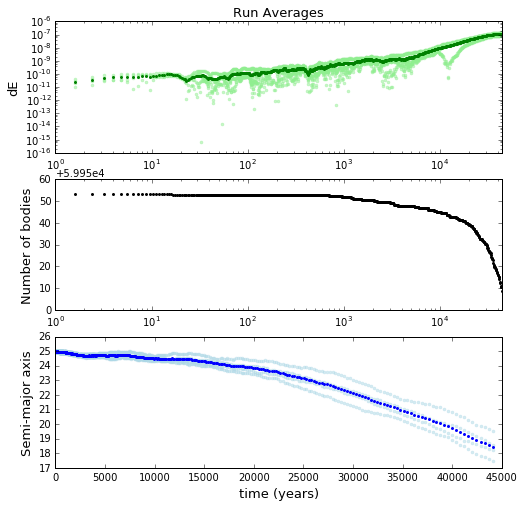

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline
filenames = get_filename(HSR,dt,0)
files = glob.glob(filenames.split("0.txt")[0]+"*.txt")
fn = len(files)

print files

#find array with shortest length (for plotting mid-run purposes)
flen = 1e10
for f in files:
    flen = min(flen,get_file_len(f))

#get data and averages
d = {}
fields=["time","dE","a","N","N_mini","ET","dt_too_large"]
for i,f in enumerate(files):
    d[i] = pd.DataFrame(np.transpose(np.genfromtxt(f, delimiter=",",unpack=True,dtype=float))[0:flen,:],columns=fields)
data = pd.Panel(d)
time = data[0].loc[:,"time"]/6.283
Eavg = data.minor_xs("dE").mean(axis=1)
Navg = data.minor_xs("N").mean(axis=1)
aavg = data.minor_xs("a").mean(axis=1)

#setup plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
alpha = 0.5
fontsize=13
maxt = max(time)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel('dE',fontsize=fontsize)
axes[0].set_xlim([1,maxt])
axes[1].set_xscale('log')
axes[1].set_ylabel('Number of bodies',fontsize=fontsize)
axes[1].set_xlim([1,maxt])
axes[2].set_ylabel('Semi-major axis',fontsize=fontsize)
axes[2].set_xlabel('time (years)',fontsize=fontsize)
axes[0].set_title("Run Averages",fontsize=fontsize)

#plot
for i in xrange(0,fn):
    axes[0].plot(time,data[i].loc[:,"dE"], '.', alpha=alpha, color='lightgreen')
    axes[2].plot(time,data[i].loc[:,"a"], '.', alpha=alpha, color='lightblue')
axes[0].plot(time, Eavg, '.', markeredgecolor='none', color='green', label='avg.')
axes[1].plot(time, Navg, '.', markeredgecolor='none', color='black', label='avg.')
axes[2].plot(time, aavg, '.', markeredgecolor='none', color='blue', label='avg.')
plt.savefig(filenames.split("0.txt")[0]+"avg.pdf") #save plot